# Expressibility and engtangling capability

In [15]:
import os
import warnings
import json
import sys
import glob
import numpy
import pickle
import random
import collections
import pennylane as qml
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import csv

from discopy.quantum.pennylane import to_pennylane, PennyLaneCircuit
from scipy.special import kl_div
from math import ceil
from pathlib import Path
from sympy import default_sort_key
from utils import transform_into_pennylane_circuits, read_diagrams, get_symbols, flatten
from qiskit.quantum_info import partial_trace, Statevector

this_folder = os.path.abspath(os.getcwd())
nshot = 1000
fidelity=[]

In [ ]:
num_of_bins = 75
bins_list = [i/(num_of_bins) for i in range(num_of_bins + 1)]
bins_x = [bins_list[1]+bins_list[i] for i in range(num_of_bins - 1)]

def P_harr(l, u, N):
    return (1-l)**(N-1)-(1-u)**(N-1)

#Harr histogram
P_harr_hist = [P_harr(bins_list[i], bins_list[i+1], 2) for i in range(num_of_bins)]

In [ ]:
workload = "execution_time"
#workload = "cardinality"

workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//"\
            + workload + "//" + workload_size + "//circuits//"\
            + str(classification) + "//" + str(layers) + "_layer//"\
           + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count)\
            + "_n_wire_count//"

In [ ]:
training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [ ]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Expressibility

In [ ]:
fidelity = []
with open('results//fidelity_execution_time_1_1_3_1_main_correct.pickle', 'rb') as handle:
    fidelity = pickle.load(handle)

In [ ]:
fidelity = [int(t) for t in fidelity]

ValueError: weights should have the same shape as x

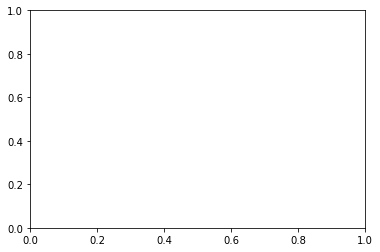

In [7]:
weights = numpy.ones_like(fidelity)/float(len(fidelity))
res = plt.hist(fidelity, bins=bins_list, weights=weights, label='Result', range=[0, 1])
plt.plot(bins_x, P_harr_hist[:-1], label='Harr random')
plt.legend(loc='upper right')
plt.show()

In [ ]:
P_I_hist = numpy.histogram(fidelity, bins = bins_list, weights = weights, range=[0, 1])[0]
kl_pq = kl_div(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

## Engtangling capability

Meyer-Wallach entanglement measure for each circuit in the training data set.

In [ ]:
def mw_engtanglement(circuits, sample_size):
    engtanglement_values = {}
    for i, c in enumerate(circuits):
        print("Progress:", i/len(circuits))
        entropies = []
        for i in range(sample_size):
            entropy = 0
            disco_circuit = circuits[c]
            current_symbols = disco_circuit.free_symbols
            params = torch.Tensor([[2*np.pi*random.uniform(0, 1)] for i in range(len(current_symbols))])
            
            qml_circuit = to_pennylane(disco_circuit)
            
            n_qubits = qml_circuit.n_qubits
            qubit_list = list(range(n_qubits))
            
            subs_params = qml_circuit.param_substitution(symbols=current_symbols, weights=params)
            qml_circuit = qml_circuit.make_circuit()
            
            state_vector = qml_circuit(subs_params).numpy()
            state_vector = Statevector(state_vector)
            
            for j in range(n_qubits):
                rest = qubit_list[:j] + qubit_list[j+1:]
                dens = partial_trace(state_vector, rest).data       
                trace = np.trace(np.matmul(dens, dens))
                entropy += trace.real
            entropy = entropy / n_qubits
            entropies.append(1.0 - entropy)
            
        Q = 2*np.sum(entropies)/sample_size
        print("Engtanglement:", Q)
        engtanglement_values[c] = Q
    
    return engtanglement_values

In [ ]:
res = mw_engtanglement(training_circuits, 10)

In [22]:
res = {}
with open('results//mw_engtanglement_execution_time_1_1_3_1_main.pickle', 'rb') as handle:
    res = pickle.load(handle)

total = 0
for k in res:
    total += float(res[k])
print(total/len(res))

0.5167863411758729
